## Vehicle Detection

In this project, my goal is to write a software pipeline to detect vehicles in a video (start with the test_video.mp4 and later implement on full project_video.mp4). 

Steps of the pipeline are:
* Prepare the training image and test image
* Extract features from image
* Prepare the data
* Train the model
* Search for cars in the the image
* Deal with duplication and false detection
* Draw rectangle on the image

### Data exploration

Vehicle Image Shape: (64, 64, 3)  Total Number: 8792
Non Vehicle Image Shape: (64, 64, 3)  Total Number: 8968


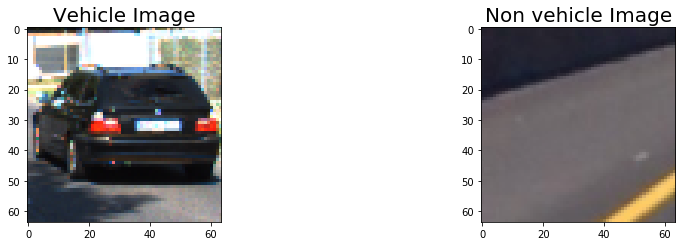

In [2]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
from skimage.feature import hog
vehicle_imgs = glob.glob('./vehicles/*/*.png')
non_vehicle_imgs = glob.glob('./non-vehicles/*/*.png')
random_idx = np.random.randint(0,len(vehicle_imgs))
vehicle = mpimg.imread(vehicle_imgs[random_idx])
non_vehicle = mpimg.imread(non_vehicle_imgs[random_idx])
print('Vehicle Image Shape:',vehicle.shape, ' Total Number:', len(vehicle_imgs))
print('Non Vehicle Image Shape:',non_vehicle.shape, ' Total Number:', len(non_vehicle_imgs))
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3))
f.tight_layout()
ax1.imshow(vehicle)
ax1.set_title('Vehicle Image', fontsize=20)
ax2.imshow(non_vehicle)
ax2.set_title('Non vehicle Image', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### First let's define a funtion to extract the feature of our test image. (This function is from the lecture practise)

In [350]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=False):
    if vis == True:
        # Use skimage.hog() to get both features and a visualization
        features = [] 
        hog_image = img 
        features, hog_image = hog(img, orientations=orient,
                          pixels_per_cell=(pix_per_cell, pix_per_cell), 
                          cells_per_block=(cell_per_block, cell_per_block), 
                          visualise=vis, feature_vector=feature_vec, block_norm="L2-Hys")
        return features, hog_image
    else:      
        # Use skimage.hog() to get features only
        features = hog(img, orientations=orient,
                          pixels_per_cell=(pix_per_cell, pix_per_cell), 
                          cells_per_block=(cell_per_block, cell_per_block), 
                          visualise=vis, feature_vector=feature_vec, block_norm="L2-Hys")
        return features

In [351]:
def get_all_hog_features(img, orient, pix_per_cell, cell_per_block):
    ch1 = img[:,:,0]
    ch2 = img[:,:,1]
    ch3 = img[:,:,2]
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block).ravel()
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block).ravel()
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block).ravel()
    features = np.concatenate((hog1,hog2,hog3))
    return features

### Test the get_hog_features and get visualization of hog image

Image size:  (64, 64, 3)
feature size:  1764


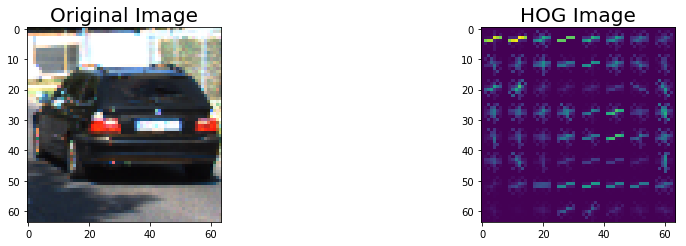

In [352]:
# parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2

# grayscale
gray = cv2.cvtColor(vehicle, cv2.COLOR_RGB2GRAY)
hog_features, hog_image = get_hog_features(gray, orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, vis=True, feature_vec=True)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3))
f.tight_layout()
ax1.imshow(vehicle)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(hog_image)
ax2.set_title('HOG Image', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

print('Image size: ', vehicle.shape)
print('feature size: ', len(hog_features))

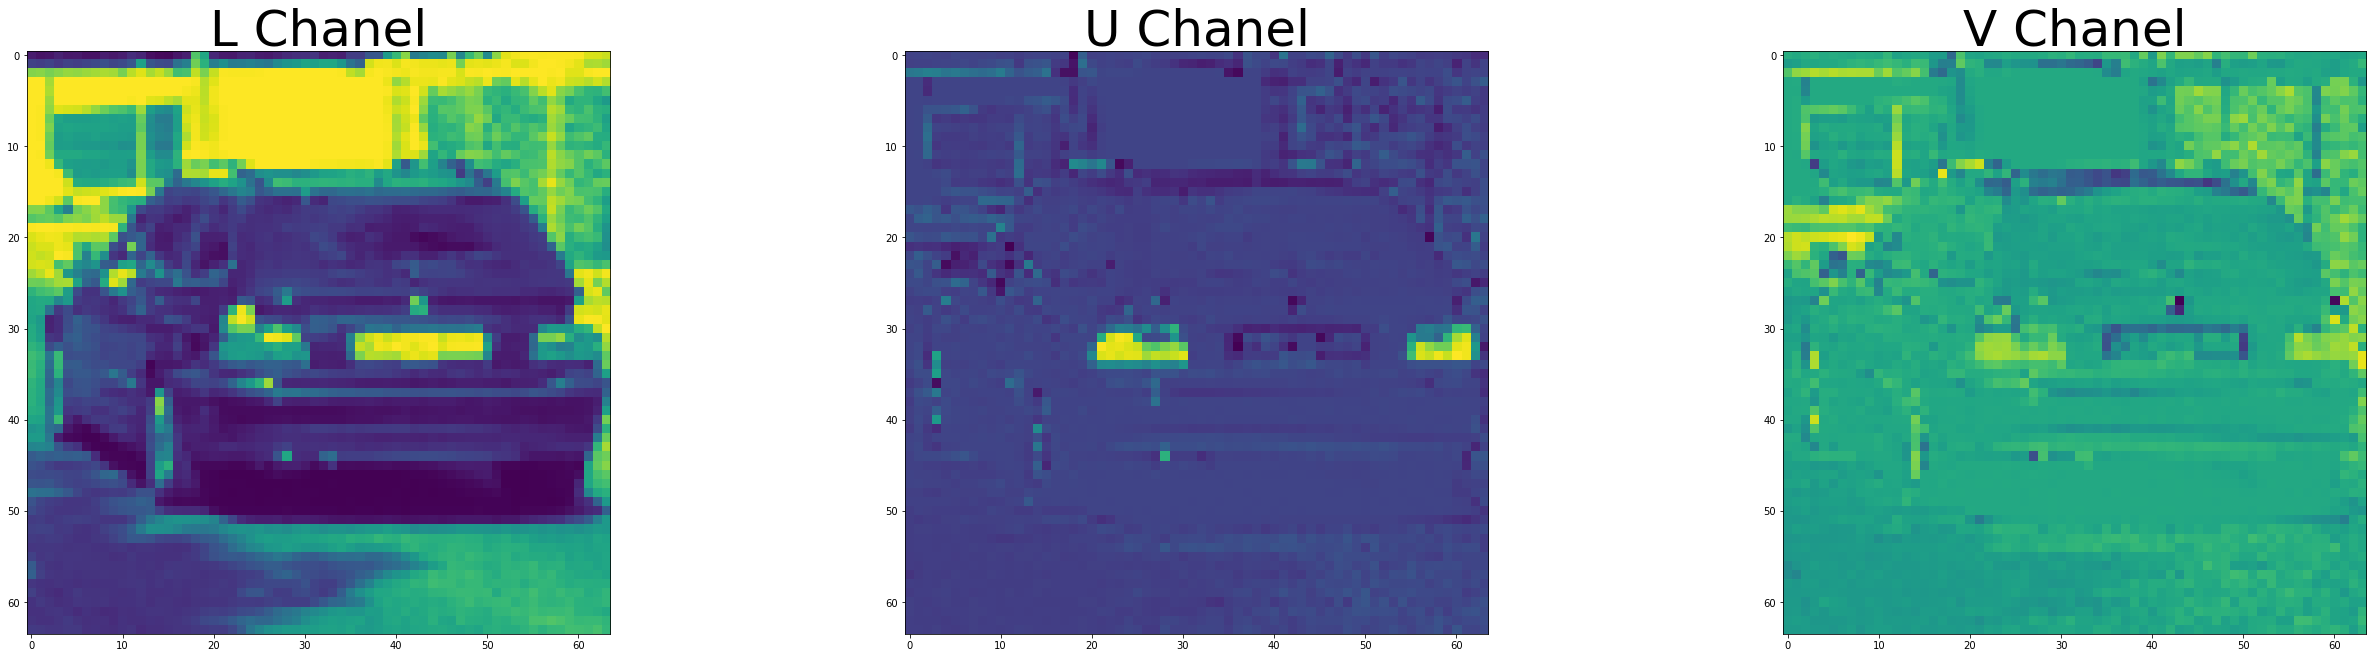

In [353]:
img = cv2.cvtColor(vehicle, cv2.COLOR_RGB2LUV)
L = img[:,:,0]
U = img[:,:,1]
V = img[:,:,2]

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(36, 9))
f.tight_layout()
ax1.imshow(L)
ax1.set_title('L Chanel', fontsize=50)
ax2.imshow(U)
ax2.set_title('U Chanel', fontsize=50)
ax3.imshow(V)
ax3.set_title('V Chanel', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Define a function to extract features from a list of images

In [899]:
def get_spatial_color_features(image, cspace='RGB',spatial=32,
                        hist_bins=32, hist_range=(0, 256)):
    # apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(image)      
  
    # Compute the histogram of the color channels separately
    # Chosse only one channel to minimize the extraction time
    # channel_hist = np.histogram(feature_image[:,:,0], bins=hist_bins, range=hist_range) # Result = 0.9918
    # channel_hist = np.histogram(feature_image[:,:,1], bins=hist_bins, range=hist_range) # Result = 0.9921
    channel_hist = np.histogram(feature_image[:,:,2], bins=hist_bins, range=hist_range) # Result = 0.9938
    # Concatenate the histograms into a single feature vector
    hist_features = channel_hist[0]
    
    spatial_features = cv2.resize(image, (spatial,spatial)).ravel()
    # Return list of feature vectors
    return np.concatenate((hist_features, spatial_features))

In [900]:
#Define a function to extract features from a list of images
def extract_features(img, cspace='RGB',
                        hist_bins=32, hist_range=(0, 255)):
    orient = 9
    pix_per_cell = 8
    cell_per_block = 2
    # Apply gray scale 
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Extract HOG features
    hog_features = get_hog_features(gray, orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, vis=False, feature_vec=True)
    # Apply get_color_features()
    color_features = get_spatial_color_features(img, cspace=cspace, hist_bins=hist_bins, hist_range=hist_range)
    # Append the new feature vector to the features list
    features = np.concatenate((hog_features, color_features))
    # Return list of feature vectors
    return features

def prepare_template_data(images):
    features = []
    for image in images:
        img = mpimg.imread(image)
        # play with color space when training
        img_features = extract_features(img,cspace='LUV')
        features.append(img_features)
    return features  

*With only HOG feature RGB:0.92, HSV: 0.95, hls:0.95 LUV:0.96 YUV:0.92, so we choose LUV*

## Train the classifier

In [901]:
car_imgs = glob.glob('./vehicles/*/*.png')
non_car_imgs = glob.glob('./non-vehicles/*/*.png')
# Extract features and labels
X_features = np.vstack((prepare_template_data(car_imgs), prepare_template_data(non_car_imgs))).astype(np.float64)
# Create labels
y_labels = np.hstack((np.ones(len(car_imgs)), np.zeros(len(non_car_imgs))))


In [903]:
from sklearn.preprocessing import StandardScaler
# Normalization
scaler = StandardScaler().fit(X_features)
print('Before normalization MAX: ', np.max(X_features), ' MIN: ', np.min(X_features))
X_normalized = scaler.transform(X_features)
print('After normalization MAX: ', np.max(X_normalized) , ' MIN: ', np.min(X_normalized))

Before normalization MAX:  18881.4918855  MIN:  0.0
After normalization MAX:  131.693845193  MIN:  -1.71315641729


In [904]:
# Split data into training data and testing data
from sklearn.cross_validation import train_test_split
seed = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y_labels, test_size=0.2, random_state=seed)

In [905]:
# from sklearn import svm, grid_search
# parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
# svr = svm.SVC()
# clf = grid_search.GridSearchCV(svr, parameters)
# clf.fit(X_train, y_train)


# print('Best parameter pairs', clf.best_params_)

In [906]:
# Create model
from sklearn import svm, grid_search
svc = svm.SVC(C=10, kernel='rbf')
svc.fit(X_train, y_train)
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

Test Accuracy of SVC =  0.9938


# Test Accuracy of SVC =  0.9938 Let's started using the classifier to search for cars

In [1041]:
def sliding_window_search(img, svc, scaler, xrange, yrange, scale=1):
    orient = 9
    pix_per_cell = 8
    cell_per_block = 2
    # Get image of the area of intest
    xstart, xstop = xrange[0], xrange[1]
    ystart, ystop = yrange[0], yrange[1]
    img_tosearch = img[ystart:ystop,xstart:xstop,:]
    # Scale the image for different box size
    if scale != 1:
        imshape = img_tosearch.shape
        img_tosearch = cv2.resize(img_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    # Change to grayscale
    gray = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2GRAY)
    # Get HOG feature
    hog_features = get_hog_features(gray, orient=orient, pix_per_cell=pix_per_cell, 
                                    cell_per_block=cell_per_block, vis=False, feature_vec=False)

    # Define blocks and steps as above
    nxblocks = (img_tosearch.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (img_tosearch.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2

    # Define window steps
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    # Define array for detected boxes
    bboxes = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            # Sliding window 
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feature = hog_features[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            # Window top left cornor in pixel
            window_y = ypos*pix_per_cell
            window_x = xpos*pix_per_cell
            sub_img = img_tosearch[window_y:window_y+window,window_x:window_x+window]
            # Extract color and spatial feature for this patch
            color_features = get_spatial_color_features(sub_img, cspace='LUV')
            # Append the new feature vector to the features list
            features = np.concatenate((hog_feature, color_features))
            # Make prediction
            X_pred = scaler.transform([features])
            
            pred = svc.predict(X_pred)
#             print searching map
#             if True: 
            if pred[0] == 1:
                xbox_left = np.int(window_x*scale)
                ytop_draw = np.int(window_y*scale)
                win_draw = np.int(window*scale)
                # Scale the image properly to draw on original image
                bboxes.append(((xstart+xbox_left, ytop_draw+ystart),(xstart+xbox_left+win_draw,ytop_draw+win_draw+ystart)))   
    return bboxes       

In [1012]:
# Here is your draw_boxes function from the previous exercise
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

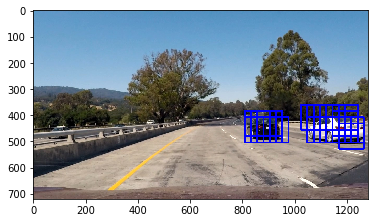

In [1013]:
test_img = mpimg.imread('./test_images/test1.jpg')
scaled_img = test_img.astype(np.float32)/255 # jpg to from (0,255) to (0,1)
xstart, xstop = 400, scaled_img.shape[1]
ystart, ystop = scaled_img.shape[0]//2, scaled_img.shape[0]
rects = sliding_window_search(scaled_img, svc, scaler,xrange=(xstart, xstop),yrange=(ystart, ystop),scale=1.5)
output = draw_boxes(test_img, rects)
plt.imshow(output)

### We only used one scale window to search on the test image, now let's make a function to run multiple times for different scale in order to get more robust result for different cars 

In [1032]:
 def search_cars(img, svc, scaler):
    bboxes = []
    # Search the most front area with smaller scale to search for smaller car
    xstart, xstop = 600, img.shape[1]
    ystart, ystop = 400, 500
    rects = sliding_window_search(img, svc, scaler,xrange=(xstart, xstop),yrange=(ystart, ystop),scale=1)
    bboxes += rects
    # Medium window size for upper area
    xstart, xstop = 400, img.shape[1]
    ystart, ystop = 400, 600
    rects = sliding_window_search(img, svc, scaler,xrange=(xstart, xstop),yrange=(ystart, ystop),scale=1.5)
    bboxes += rects
    # Large window fo close area
    xstart, xstop = 300, img.shape[1]
    ystart, ystop = 500, 720
    rects = sliding_window_search(img, svc, scaler,xrange=(xstart, xstop),yrange=(ystart, ystop),scale=3)
    bboxes += rects
    
    return bboxes 

Text(0.5,1,'Area of Interest')

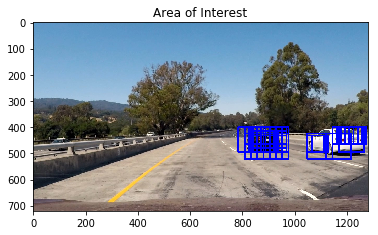

In [1033]:
test_img = mpimg.imread('./test_images/test1.jpg')
scaled_img = test_img.astype(np.float32)/255 # jpg to from (0,255) to (0,1)
rects = search_cars(scaled_img, svc, scaler)
output = draw_boxes(test_img, rects)
plt.imshow(output)
plt.title('Area of Interest')

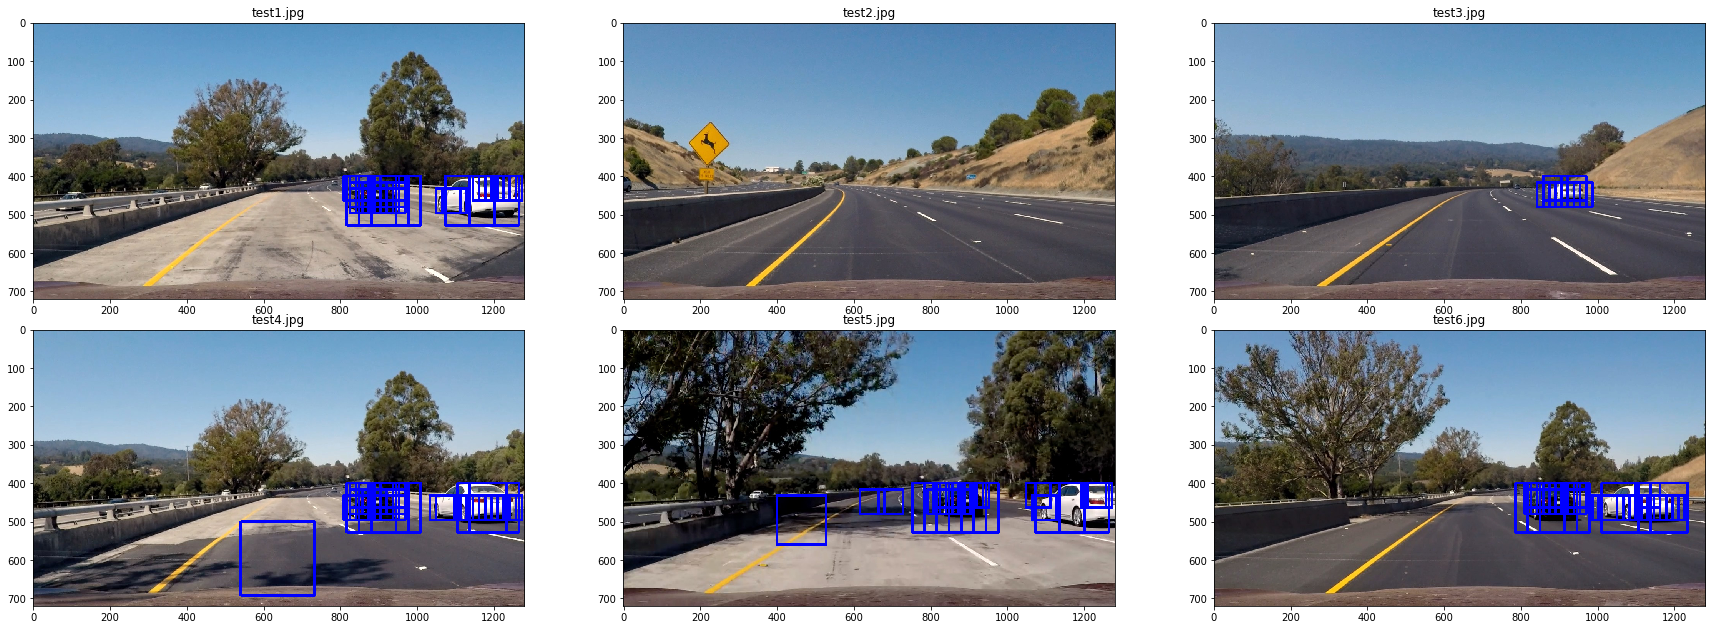

In [956]:
imgs = glob.glob('./test_images/*.jpg')
f, axes = plt.subplots(2, 3, figsize=(24, 9))
axes = axes.ravel()
f.tight_layout()

for key,img in enumerate(imgs):
    ax = axes[key]
    image = mpimg.imread(img)
    scaled_img = image.astype(np.float32)/255 # jpg to from (0,255) to (0,1)
    rects = search_cars(scaled_img, svc, scaler)
    output = draw_boxes(image, rects)
    ax.imshow(output)
    ax.set_title(img.split('/')[-1])
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [729]:
from scipy.ndimage.measurements import label

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

def get_labeled_bboxes(labels):
    bboxes = []
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
#         cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
        bboxes.append(bbox)
    # Return the image
#     return img
    return bboxes

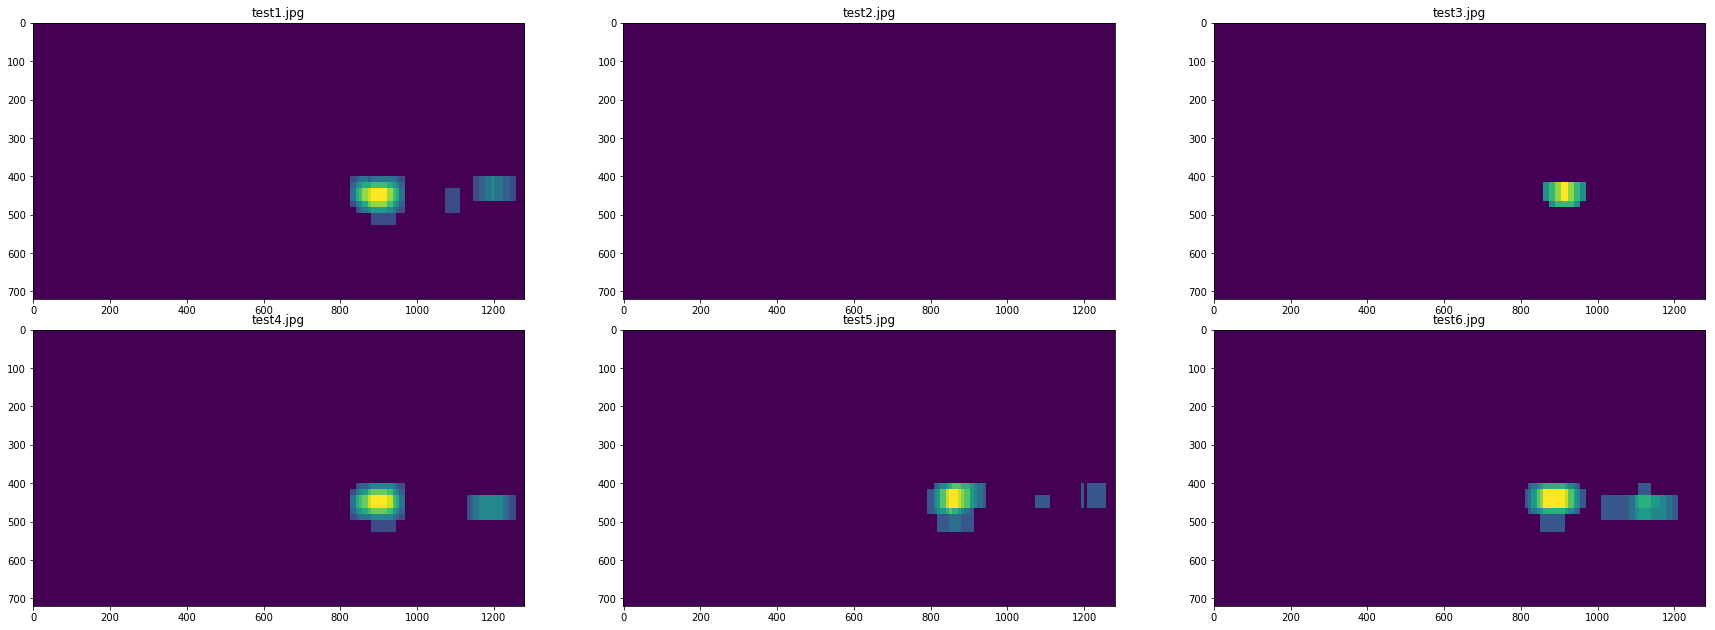

In [959]:
imgs = glob.glob('./test_images/*.jpg')
f, axes = plt.subplots(2, 3, figsize=(24, 9))
axes = axes.ravel()
f.tight_layout()

for key,img in enumerate(imgs):
    ax = axes[key]
    image = mpimg.imread(img)
    scaled_img = image.astype(np.float32)/255 # jpg to from (0,255) to (0,1)
    rects = search_cars(scaled_img, svc, scaler)
    output = draw_boxes(image, rects)
    heat = np.zeros_like(output[:,:,0]).astype(np.float)
    heat = add_heat(heat, rects)
    heatmap = np.clip(heat,0,255)
    heatmap = apply_threshold(heatmap, 2)
    labels = label(heatmap)
    
    output_image = draw_labeled_bboxes(test_img, labels)
    ax.imshow(heatmap)
    ax.set_title(img.split('/')[-1])
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

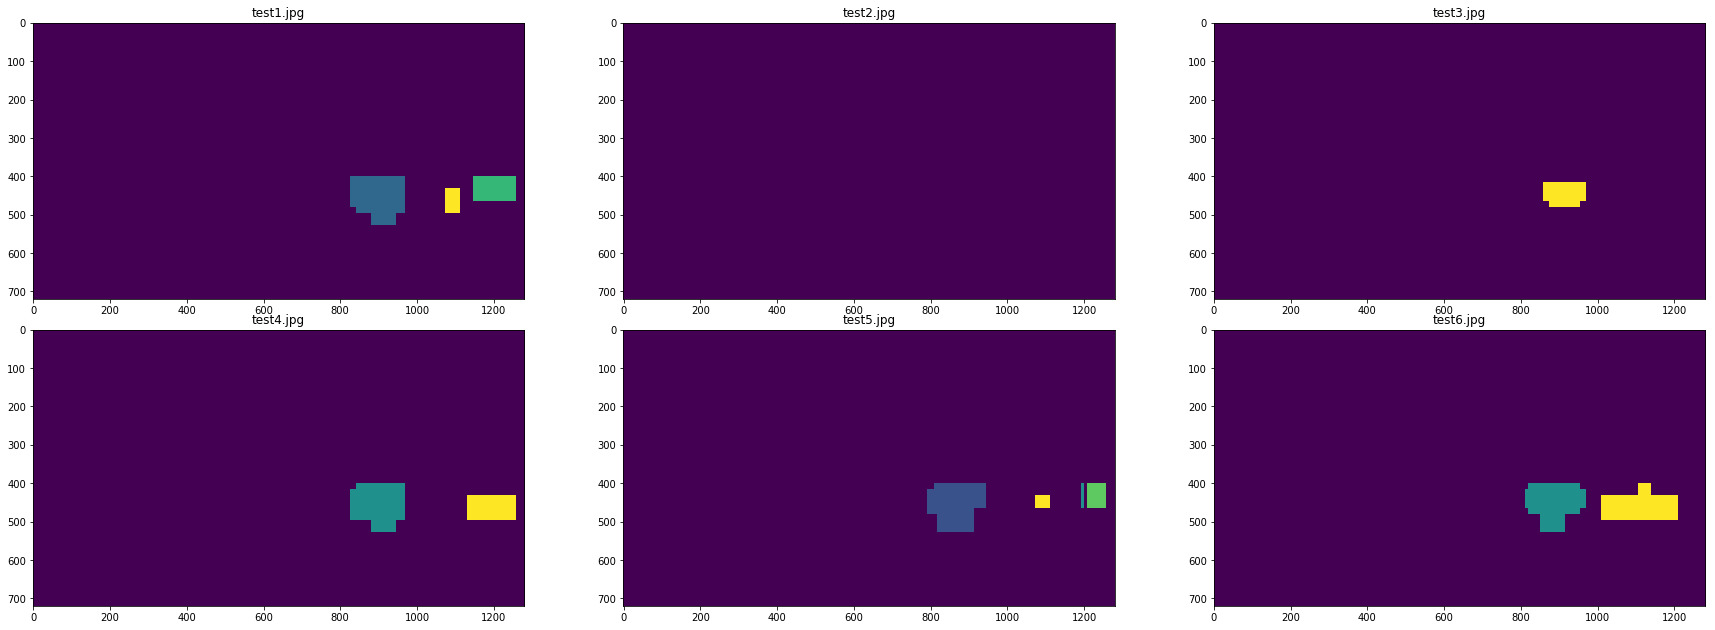

In [960]:
imgs = glob.glob('./test_images/*.jpg')
f, axes = plt.subplots(2, 3, figsize=(24, 9))
axes = axes.ravel()
f.tight_layout()

for key,img in enumerate(imgs):
    ax = axes[key]
    image = mpimg.imread(img)
    scaled_img = image.astype(np.float32)/255 # jpg to from (0,255) to (0,1)
    rects = search_cars(scaled_img, svc, scaler)
    output = draw_boxes(image, rects)
    heat = np.zeros_like(output[:,:,0]).astype(np.float)
    heat = add_heat(heat, rects)
    heatmap = np.clip(heat,0,255)
    heatmap = apply_threshold(heatmap, 2)
    labels = label(heatmap)
    
    output_image = draw_labeled_bboxes(test_img, labels)
    ax.imshow(labels[0])
    ax.set_title(img.split('/')[-1])
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

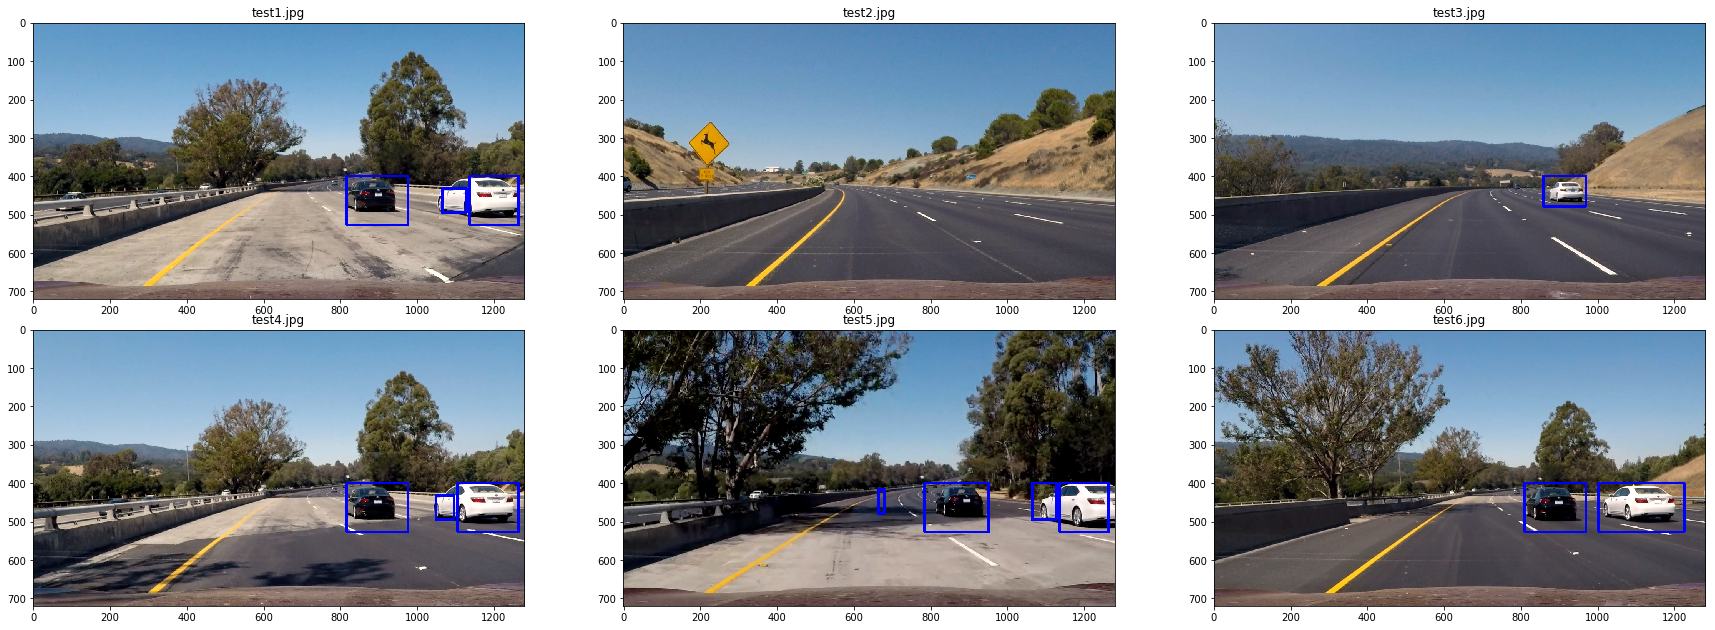

In [965]:
imgs = glob.glob('./test_images/*.jpg')
f, axes = plt.subplots(2, 3, figsize=(24, 9))
axes = axes.ravel()
f.tight_layout()

for key,img in enumerate(imgs):
    ax = axes[key]
    image = mpimg.imread(img)
    scaled_img = image.astype(np.float32)/255 # jpg to from (0,255) to (0,1)
    rects = search_cars(scaled_img, svc, scaler)
    output = draw_boxes(image, rects)
    heat = np.zeros_like(output[:,:,0]).astype(np.float)
    heat = add_heat(heat, rects)
    heatmap = np.clip(heat,0,255)
    heatmap = apply_threshold(heatmap, 1)
    labels = label(heatmap)
    
    output_image = draw_labeled_bboxes(image, labels)
    ax.imshow(output_image)
    ax.set_title(img.split('/')[-1])
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [983]:
class Car():
    def __init__(self):
        # Detection status
        self.detected = False
        # The most recent center positions
        self.recent_positions = []
        # The average center position
        self.best_position = ((0,0),(0,0))
        # Current center 
        self.current_center = ()
        # Number of frames missing 
        self.undetected_count = 0
        
    # Add detected car box to car object    
    def add(self,box): 
        self.recent_positions.append(box)
        # Calculate the center position of new box
        self.current_center = np.mean(box,axis=0)
        if len(self.recent_positions) > 25:
            # Only keep 20 detected boxes to get best center postion
            self.recent_positions.pop(0) 
            self.best_position = np.mean(self.recent_positions,axis=0, dtype=np.integer) 
        elif len(self.recent_positions) >= 6:
            # Only display the box when there are more than 6 frames   
            self.best_position = np.mean(self.recent_positions,axis=0,dtype=np.integer)
        
    # Validate the detected box    
    def validDetection(self, center):
        margin = 30
        # If the new center is in the margin of the current center, it's the same car
        # If not in the margin ,it's a new car
        if len(self.current_center) != 0:
            xrange = [self.current_center[0] - margin, self.current_center[0] + margin]
            yrange = [self.current_center[1] - margin, self.current_center[1] + margin]
            if center[0] < xrange[0] or center[0] > xrange[1] or center[1] < yrange[0] or center[1] > yrange[1]:
                return False
        return True

In [984]:
# Build the pipline
def process_img(img):
    # Get detected cars
    global global_cars

    # Scale the value to (0,1)
    if np.max(img) > 1:
        scaled_img = img.astype(np.float32)/255
    else:
        scaled_img = np.copy(img)
    # search for cars     
    rects = search_cars(scaled_img, svc, scaler)   

    # Create blank heatmap
    heatmap = np.zeros_like(img[:,:,0]).astype(np.float)
    # Add heat to the heatmap
    heatmap = add_heat(heatmap, rects)
    # Limit the value between 0 and it's max
    heatmap = np.clip(heatmap,0,255)
    # Apply threshold to remove overlaps and false detection
#     heatmap = apply_threshold(heatmap, 3)
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    # Update car object
    bboxes = get_labeled_bboxes(labels)

    for bbox in bboxes:
        fit = False
        for car in global_cars:
            fit = car.validDetection(np.mean(bbox,axis=0))
            # If the center fit in this car 
            if fit:
                car.add(bbox)
                # Set detection status to true
                car.detected = True
                # Rest undtected_count number
                car.undetected_count = 0
                break
        # If doesn't fit in any existing car        
        if not fit:
            # Create a new car object
            car = Car()
            car.add(bbox)
            global_cars.append(car)
    
    # Draw cars 
    key = 0
    for i in range(len(global_cars)):
        car = global_cars[key]
        if car.detected :
            # Draw the box if the detecte status is true
            img = cv2.rectangle(img, tuple(car.best_position[0]), tuple(car.best_position[1]), (0,0,255), 6)
            # Reset status
            car.detected = False
            key += 1
        elif car.undetected_count <= 5:
            # Draw last detection if not missing 3 frames in a row
            img = cv2.rectangle(img, tuple(car.best_position[0]), tuple(car.best_position[1]), (0,0,255), 6)
            car.undetected_count += 1
            key += 1
        else:
            # Delete the car object
            global_cars.pop(key)
            
    return img

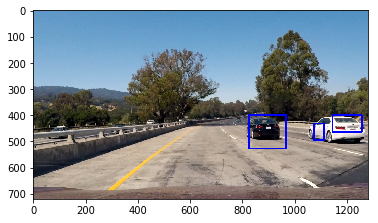

In [976]:
global_cars = []
for i in range(6):
    test_img = mpimg.imread('./test_images/test1.jpg')
    out = process_img(test_img)
plt.imshow(out)

In [970]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [1042]:
global_cars = []

white_output = 'output_videos/test_video.mp4'
clip1 = VideoFileClip("test_videos/test_video.mp4")
white_clip = clip1.fl_image(process_img) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video output_videos/test_video.mp4
[MoviePy] Writing video output_videos/test_video.mp4



 97%|█████████▋| 38/39 [02:28<00:03,  3.56s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/test_video.mp4 

CPU times: user 2min 26s, sys: 1.28 s, total: 2min 27s
Wall time: 2min 29s


In [1043]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [1044]:
global_cars = []

white_output = 'output_videos/project_video1.mp4'
clip1 = VideoFileClip("test_videos/project_video.mp4")
white_clip = clip1.fl_image(process_img) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video output_videos/project_video1.mp4
[MoviePy] Writing video output_videos/project_video1.mp4



 12%|█▏        | 147/1261 [08:53<1:09:51,  3.76s/it]


 23%|██▎       | 293/1261 [17:54<58:51,  3.65s/it]


 35%|███▌      | 444/1261 [27:13<50:17,  3.69s/it]


 47%|████▋     | 595/1261 [36:33<41:33,  3.74s/it]


 59%|█████▉    | 746/1261 [45:19<28:33,  3.33s/it]


 71%|███████   | 897/1261 [54:43<23:10,  3.82s/it]


 83%|████████▎ | 1045/1261 [1:04:04<13:51,  3.85s/it]


 94%|█████████▍| 1188/1261 [1:13:09<04:28,  3.67s/it]


100%|█████████▉| 1260/1261 [1:17:33<00:03,  3.44s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/project_video1.mp4 

CPU times: user 1h 16min 58s, sys: 24.4 s, total: 1h 17min 22s
Wall time: 1h 17min 33s


In [1045]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))